In [23]:
!date

Mon Sep 23 18:42:46 EDT 2024


In [24]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-denoise/Code'

In [25]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model

In [26]:
import ants
from tqdm import tqdm

In [27]:
def correlation(x,y):
  x_mean = np.repeat(x.mean(),x.shape,axis=0)
  y_mean = np.repeat(y.mean(),y.shape,axis=0)
  cov = (x-x_mean)*(y-y_mean)
  r = cov.sum()/(x.std()*y.std()*x.shape[0])
  return r

def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

def compute_in(x):
  return (x-3)/2+1

def compute_in_size(x):
  for i in range(4):
    x = compute_in(x)
  return x

def compute_out_size(x):
  return ((((x*2+1)*2+1)*2+1)*2+1)

def compute_padding(x):
  rounding = np.ceil(compute_in_size(x))-compute_in_size(x)
  y = ((((rounding*2)*2)*2)*2)
  pad = bin(int(y)).replace('0b', '')
  if len(pad) < 4:
      for i in range(4-len(pad)):
          pad = '0' + pad
  final_size = compute_in_size(x+y)
  pad_out = bin(int(compute_out_size(final_size)-x)).replace('0b','')
  if len(pad_out) < 4:
      for i in range(4-len(pad_out)):
          pad_out = '0' + pad_out
  return pad,final_size, pad_out

In [28]:
class Scaler():
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large


In [29]:
class TrainDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.obs = X
    self.noi = Y

  def __len__(self):
    return min(self.obs.shape[0],self.noi.shape[0])

  def __getitem__(self, index):
    observation = self.obs[index]
    noise = self.noi[index]
    s = 2*random.beta(4,4,1)
    noise_aug = s*noise
    return observation, noise_aug

class DenoiseDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X):
    self.obs = X
    
  def __len__(self):
    return self.obs.shape[0]

  def __getitem__(self, index):
    observation = self.obs[index]
    return observation



In [30]:
class cVAE(nn.Module):

    def __init__(self,in_channels: int,in_dim: int, latent_dim: int,hidden_dims: List = None) -> None:
        super(cVAE, self).__init__()

        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.in_dim = in_dim

        modules_z = []
        if hidden_dims is None:
            hidden_dims = [64, 128, 256, 256]
        
        self.pad, self.final_size, self.pad_out = compute_padding(self.in_dim)

        # Build Encoder
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_z.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_z = nn.Sequential(*modules_z)
        self.fc_mu_z = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)
        self.fc_var_z = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)

        modules_s = []
        in_channels = self.in_channels
        for i in range(len(hidden_dims)):
            h_dim = hidden_dims[i]
            modules_s.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = int(self.pad[-i-1])),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder_s = nn.Sequential(*modules_s)
        self.fc_mu_s = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)
        self.fc_var_s = nn.Linear(hidden_dims[-1]*int(self.final_size), latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(2*latent_dim, hidden_dims[-1] * int(self.final_size))

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=int(self.pad_out[-4+i]),
                                    output_padding=int(self.pad_out[-4+i])),
                    nn.BatchNorm1d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )


        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=int(self.pad_out[-1]),
                                               output_padding=int(self.pad_out[-1])),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1))
           #out_channels

    def encode_z(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_z(input)
  
        result = torch.flatten(result, start_dim=1)


        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_z(result)
        log_var = self.fc_var_z(result)

        return [mu, log_var]

    def encode_s(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder_s(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu_s(result)
        log_var = self.fc_var_s(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1,256,int(self.final_size))
        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward_tg(self, input: Tensor) -> List[Tensor]:
        tg_mu_z, tg_log_var_z = self.encode_z(input)
        tg_mu_s, tg_log_var_s = self.encode_s(input)
        tg_z = self.reparameterize(tg_mu_z, tg_log_var_z)
        tg_s = self.reparameterize(tg_mu_s, tg_log_var_s)
        output = self.decode(torch.cat((tg_z, tg_s),1))
        return  [output, input, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s]

    def forward_bg(self, input: Tensor) -> List[Tensor]:
        bg_mu_s, bg_log_var_s = self.encode_s(input)
        bg_s = self.reparameterize(bg_mu_s, bg_log_var_s)
        zeros = torch.zeros_like(bg_s)
        output = self.decode(torch.cat((zeros, bg_s),1))
        return  [output, input, bg_mu_s, bg_log_var_s]

    def forward_fg(self, input: Tensor) -> List[Tensor]:
        fg_mu_z, fg_log_var_z = self.encode_z(input)
        tg_z = self.reparameterize(fg_mu_z, fg_log_var_z)
        zeros = torch.zeros_like(tg_z)
        output = self.decode(torch.cat((tg_z, zeros),1))
        return  [output, input, fg_mu_z, fg_log_var_z]

    def loss_function(self,
                      *args,
                      ) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        beta = 0.00001
        gamma = 1

        recons_tg = args[0]
        input_tg = args[1]
        tg_mu_z = args[2]
        tg_log_var_z = args[3]
        tg_mu_s = args[4]
        tg_log_var_s = args[5]
        tg_z = args[6]
        tg_s = args[7]
        recons_bg = args[8]
        input_bg = args[9]
        bg_mu_s = args[10]
        bg_log_var_s = args[11]

        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons_tg, input_tg)
        recons_loss += F.mse_loss(recons_bg, input_bg)
        # recons_loss *= input_shape[0]*input_shape[1]

        # z1 = tg_z[:int(batch_size/2),:]
        # z2 = tg_z[int(batch_size/2):,:]
        # s1 = tg_s[:int(batch_size/2),:]
        # s2 = tg_s[int(batch_size/2):,:]
        # q_bar = torch.cat(torch.cat((s1,z2),1),torch.cat((s2,z1),1),0)
        # q = torch.cat(torch.cat((s1,z1),1),torch.cat((s2,z1),1),0)
        # q_bar_score = nn.Sigmoid(q_bar)
        # q_score = nn.Sigmoid(q)
        # tc_loss = torch.log(q_score/(1-q_score))
        # discriminator_loss = - torch.log(q_score) - torch.log(1-q_bar_score)

        kld_loss = 1 + tg_log_var_z - tg_mu_z ** 2 - tg_log_var_z.exp()
        kld_loss += 1 + tg_log_var_s - tg_mu_s ** 2 - tg_log_var_s.exp()
        kld_loss += 1 + bg_log_var_s - bg_mu_s ** 2 - bg_log_var_s.exp()
        kld_loss = torch.mean(-0.5 * torch.sum(kld_loss, dim = 1), dim = 0)

        loss = torch.mean(recons_loss + beta*kld_loss)
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD': kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward_fg(x)[0]

In [31]:
indir = '../Data/020-fmriprepped/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii')
cf_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_CF.nii')
gm_fn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/anat/analysis_mask_GM.nii')

subs = [sub for sub in subs_orig if all(( 
    os.path.exists(epi_fn.format(sub=sub,r=1)),
    os.path.exists(epi_fn.format(sub=sub,r=2)),
    os.path.exists(cf_fn.format(sub=sub)),
    os.path.exists(gm_fn.format(sub=sub)),
    ))]

subs.sort()
print(f'{len(subs)}/{len(subs_orig)}')

34/34


In [32]:
s = 4
r = 1

In [33]:
s = int(s)
r = int(r)

sub = subs[s]
print(sub)

epi = ants.image_read(epi_fn.format(sub=sub,r=r))
gm = ants.image_read(gm_fn.format(sub=sub))
cf = ants.image_read(cf_fn.format(sub=sub))

nt = epi.shape[-1] # Number of timepoints
ndummy = 8 # how many dummies to discard

epi_flat = epi.numpy().reshape(-1,nt).transpose() # (370, 1082035)
epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
epi_flat = epi_flat.transpose()
gm_flat = gm.numpy().flatten().astype(int) # (1082035,)
cf_flat = cf.numpy().flatten().astype(int) # (1082035,)
assert max(np.unique(cf_flat+gm_flat))!=2, 'overlap' # Check for overlap again

sub-NDARINV6WXU5DEY


In [34]:
print(epi_flat.shape)
print(sum(gm_flat==1))
print(sum(cf_flat==1))

(1082035, 370)
124272
110412


In [35]:
func_gm = epi_flat[gm_flat==1,:]
func_cf = epi_flat[cf_flat==1,:]

In [36]:
print(func_gm.shape)
print(func_cf.shape)

(124272, 370)
(110412, 370)


In [50]:
#Normalization of Data
func_gm = remove_std0(func_gm)
func_cf = remove_std0(func_cf)
print(func_gm.shape)
print(func_cf.shape)

(124254, 370)
(110317, 370)


In [51]:
obs_scale = Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
print(obs_list.shape)
noi_scale = Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)
print(noi_list.shape)

(124254, 370)
(110317, 370)


In [52]:
# DataLoader
train_inputs = TrainDataset(obs_list,noi_list)

# dataloading 
train_in = torch.utils.data.DataLoader(train_inputs, batch_size=64,
                                             shuffle=True, num_workers=1)

# cVAE model
Tensor = TypeVar('torch.tensor')
model = cVAE(1,func_cf.shape[1],8)

In [53]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Training the Model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch_size = 64
epoch_num = 200
running_loss_L = []
running_recons_L = []
running_KLD_L = []

In [54]:
for epoch in tqdm(range(epoch_num)):  # loop over the dataset multiple times    
    running_loss = 0.0
    running_reconstruction_loss = 0.0
    running_KLD = 0.0

    # Iterate over data.
    dataloader_iter_in = iter(train_in)
    for i in range(len(train_in)):
        inputs_gm,inputs_cf = next(dataloader_iter_in)

        inputs_gm = inputs_gm.unsqueeze(1).float().to(device)
        inputs_cf = inputs_cf.unsqueeze(1).float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # encoder + decoder
        [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x] = model.forward_tg(inputs_gm)
        [outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s] = model.forward_bg(inputs_cf)
        outputs = torch.concat((outputs_gm,outputs_cf),1)
        loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_x, outputs_cf, inputs_cf, bg_mu_s, bg_log_var_s)
        # backward + optimize
        loss['loss'].backward()
        optimizer.step()
        running_loss += loss['loss']
        running_reconstruction_loss += loss['Reconstruction_Loss']
        running_KLD += loss['KLD']   

    epoch_running_loss = running_loss / (len(train_in)*2)
    epoch_running_reconstruction_loss = running_reconstruction_loss / (len(train_in)*2)
    epoch_running_KLD = running_KLD / (len(train_in)*2)
    running_loss_L.append(epoch_running_loss.cpu().detach().numpy())
    running_recons_L.append(epoch_running_reconstruction_loss.cpu().detach().numpy())
    running_KLD_L.append(epoch_running_KLD.cpu().detach().numpy())

100%|█████████████████████████████████████████████| 1/1 [00:27<00:00, 27.90s/it]


Text(0.5, 1.0, 'CF in/out: corr: 0.74')

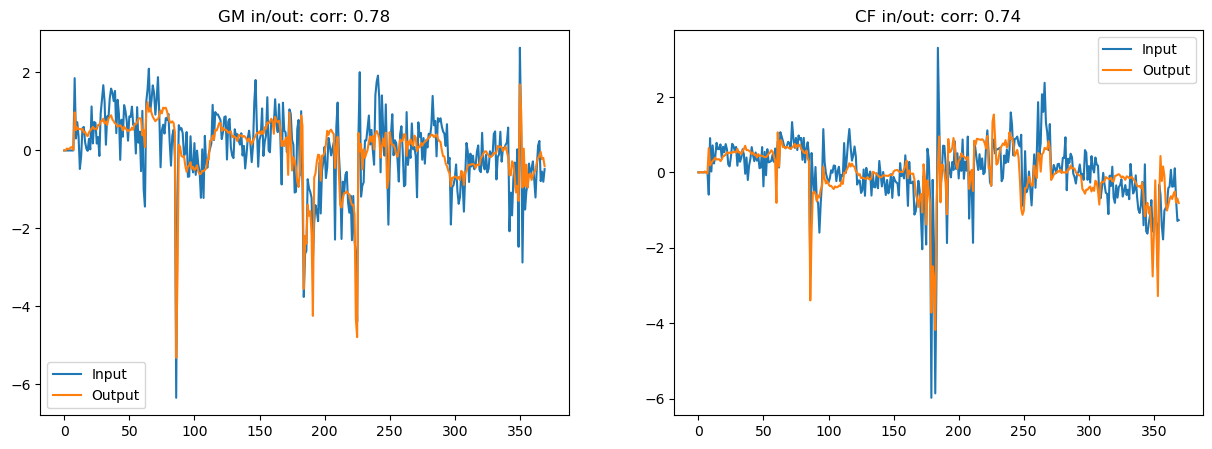

In [55]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
v1 = inputs_gm.detach().cpu().numpy()[0,0,:]
v2 = outputs_gm.detach().cpu().numpy()[0,0,:]
plt.plot(v1)
plt.plot(v2)
plt.title(f'GM in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')
plt.legend(['Input','Output'])

plt.subplot(1,2,2)
v1 = inputs_cf.detach().cpu().numpy()[0,0,:]
v2 = outputs_cf.detach().cpu().numpy()[0,0,:]
plt.plot(v1)
plt.plot(v2)
plt.legend(['Input','Output'])
plt.title(f'CF in/out: corr: {np.corrcoef(v1,v2)[0,1]:.2f}')

Text(0.5, 1.0, 'running_KLD_L')

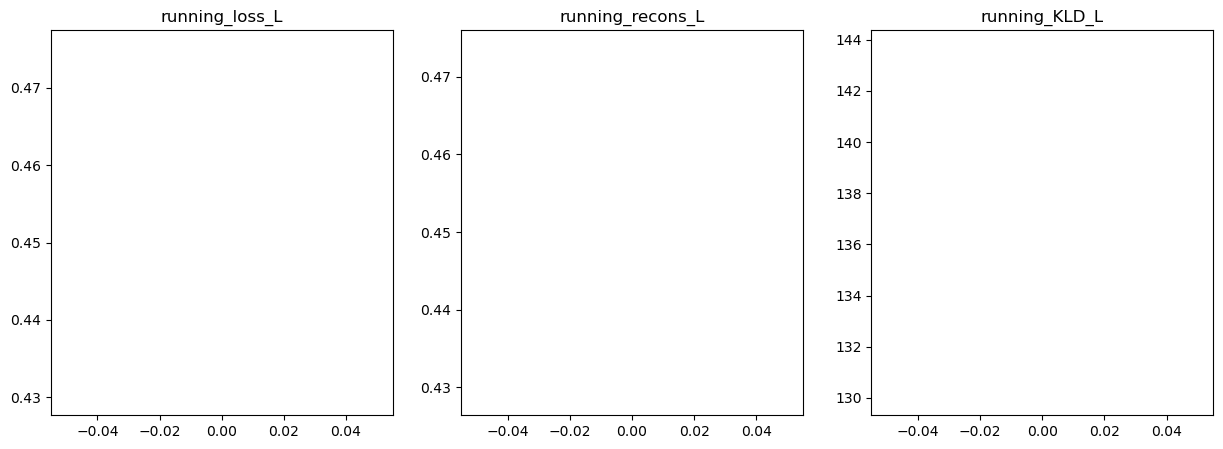

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(running_loss_L);plt.title('running_loss_L')

plt.subplot(1,3,2)
plt.plot(running_recons_L);plt.title('running_recons_L')

plt.subplot(1,3,3)
plt.plot(running_KLD_L);plt.title('running_KLD_L')

In [57]:
func_data = obs_list

In [58]:
func_data.shape

(124254, 370)

In [59]:
denoise_inputs = DenoiseDataset(func_data)
denoise_in = torch.utils.data.DataLoader(denoise_inputs, batch_size=64,
                                              shuffle=False, num_workers=1)

In [60]:
denoise_iter_in = iter(denoise_in)
for i in tqdm(range(len(denoise_in))):
    inputs = next(denoise_iter_in)
    inputs = inputs.unsqueeze(1).float().to(device)
    func_output = model.generate(inputs)
    func_output_np = func_output.squeeze().cpu().detach().numpy()
    if i == 0:
        outputs_all = func_output_np 
    else:
        outputs_all = np.concatenate((outputs_all,func_output_np), axis = 0)

100%|███████████████████████████████████████| 1942/1942 [01:07<00:00, 28.85it/s]


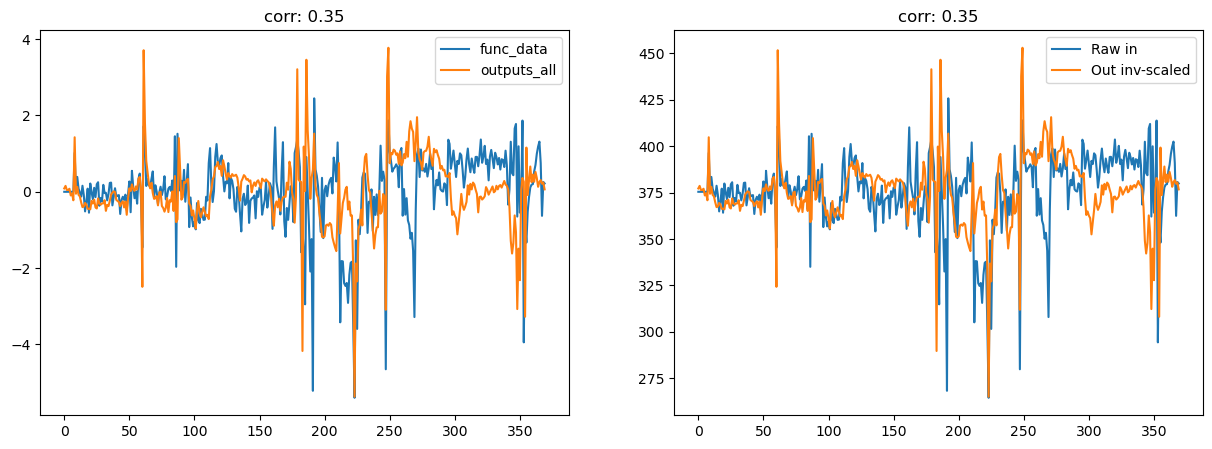

In [61]:
v = 500
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(func_data[v,:])
plt.plot(outputs_all[v,:])
plt.legend(['func_data','outputs_all'])
plt.title(f'corr: {np.corrcoef(func_data[v,:],outputs_all[v,:])[0,1]:.2f}')

plt.subplot(1,2,2)
plt.plot(epi_flat[gm_flat==1,:][v,:])
plt.plot(obs_scale.inverse_transform(outputs_all)[v,:])
plt.title(f'corr: {np.corrcoef(epi_flat[gm_flat==1,:][v,:],obs_scale.inverse_transform(outputs_all)[v,:])[0,1]:.2f}')
plt.legend(['Raw in','Out inv-scaled'])

In [137]:
denoised_flat = np.zeros(epi_flat.shape)
#denoised_flat[gm_flat==1,:]=obs_scale.inverse_transform(outputs_all) # ORIG no work
#denoised_flat[gm_flat==1,:][~(epi_flat[gm_flat==1,:].std(axis=1)==0.0),:] = obs_scale.inverse_transform(outputs_all) # Takes into account std0 voxels

vec1 = gm_flat==1
vec2 = epi_flat.std(axis=1)!=0.0
vec3 = vec1*vec2
denoised_flat[vec3,:] = obs_scale.inverse_transform(outputs_all) # Takes into account std0 voxels

#denoised_flat = denoised_flat+epi_flat.mean(axis=0) # Aesthetics
#denoised_mat = denoised_flat.transpose().reshape(epi.shape)
denoised_mat = denoised_flat.reshape(epi.shape)

denoised = epi.new_image_like(denoised_mat)
ofn = os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_space-MNI152NLin2009cAsym_res-2_desc-DEEPCOR_bold.nii'.format(sub=sub,r=r))
denoised.to_filename(ofn)

In [138]:
[denoised_flat.mean(),denoised_flat.min(),denoised_flat.max()]

[31.074557185460048, -516.631591796875, 1135.72314453125]

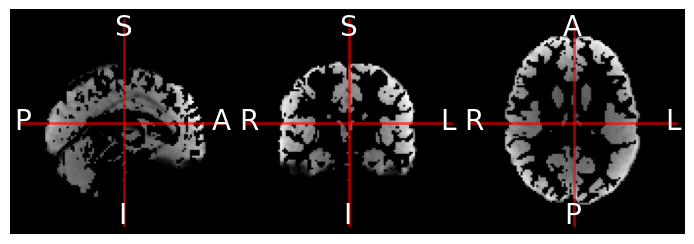

In [139]:
ants.slice_image(denoised,axis=3,idx=0).plot_ortho(flat=True)
#ants.slice_image(denoised,axis=3,idx=0).to_filename(os.path.join(indir,'{sub}/ses-baselineYear1Arm1/func/play.nii'.format(sub=sub)))